In [12]:
import os
import io
import numpy as np
import sklearn as sk
import sklearn.model_selection
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import export_graphviz
from sklearn.metrics import accuracy_score
import pandas as pd
import collections
import matplotlib.pyplot as plt
import pydotplus
#import graphviz as g

#Model taken from https://www.geeksforgeeks.org/python-decision-tree-regression-using-sklearn/


In [13]:
## Import and prepare data

df=pd.read_csv('data_full.csv')

print(df) #Uncomment to see imported data

    protein      tm                                           sequence
0      1ju3  307.95  MVDGNYSVASNVMVPMRDGVRLAVDLYRPDADGPVPVLLVRNPYDK...
1      1hml  312.95  MRFFVPLFLVGILFPAILAKQFTKCELSQLLKDIDGYGGIALPELI...
2    1ihb_a  314.65  MAEPWGNELASAAARGDLEQLTSLLQNNVNVNAQNGFGRTALQVMK...
3      1blc  314.75  KELNDLEKKYNAHIGVYALDTKSGKEVKFNSDKRFAYASTSKAINS...
4      1d0b  315.25  ETITVSTPIKQIFPDDAFAETIKDNLKKKSVTDAVTQNELNSIDQI...
5    1chk_a  316.35  AGAGLDDPHKKEIAMELVSSAENSSLDWKAQYKYIEDIGDGRGYTG...
6      1aqh  316.85  TPTTFVHLFEWNWQDVAQECEQYLGPKGYAAVQVSPPNEHITGSQW...
7      1mac  317.65  GSVFWEPLSYFNPSTWEKADGYSNGGVFNCTWRANNVNFTNDGKLK...
8      1s3g  317.75  MNIVLMGLPGAGKGTQADRIVEKYGTPHISTGDMFRAAIQEGTELG...
9      1fga  318.15  PALPEDGGSGAFPPGHFKDPKRLYCKNGGFFLRIHPDGRVDGVREK...
10   1rtp_1  318.95  SMTDLLSAEDIKKAIGAFTAADSFDHKKFFQMVGLKKKSADDVKKV...
11   2wsy_a  319.15  MERYENLFAQLNDRREGAFVPFVTLGDPGIEQSLKIIDTLIDAGAD...
12   1efc_a  319.65  SKEKFERTKPHVNVGTIGHVDHGKTTLTAAITTVLAKTYGGAARAF...
13    

In [14]:
# Divide data into testing and training sets
X = df.drop(['tm'], axis=1)
Y = df['tm']
xTrain, xTest, yTrain, yTest, = sk.model_selection.train_test_split(X, Y, test_size = 1/5, random_state = 0)
print(xTrain)

    protein                                           sequence
15     1p3j  MNLVLMGLPGAGKGTQGERIVEDYGIPHISTGDMFRAAMKEETPLG...
158    1ymb  GLSDGEWQQVLNVWGKVEADIAGHGQEVLIRLFTGHPETLEKFDKF...
7      1mac  GSVFWEPLSYFNPSTWEKADGYSNGGVFNCTWRANNVNFTNDGKLK...
159    1pgx  MDPGDASELTPAVTTYKLVINGKTLKGETTTKAVDAETAEKAFKQY...
207    1brf  AKWVCKICGYIYDEDAGDPDNGISPGTKFEELPDDWVCPICGAPKS...
152  1yu5_x  PTKLETFPLDVLVNTAAEDLPRGVDPSRKENHLSDEDFKAVFGMTR...
157  1ha4_a  GQYKIQIFEKGDFSGQMYETTEDCPSIMEQFHMREIHSCKVLEGVW...
106    2wan  DSTSTKVIVHYHRFDSNYTNWDVWMWPYQPVNGNGAAYQFTGTNDD...
122    1cyo  SKAVKYYTLEEIQKHNNSKSTWLILHYKVYDLTKFLEEHPGGEEVL...
83     1fhl  ALTYRGADISSLLLLEDEGYSYKNLNGQTQALETILADAGINSIRQ...
33     2rn2  MLKQVEIFTDGSCLGNPGPGGYGAILRYRGREKTFSAGYTRTTNNR...
139    1r69  SISSRVKSKRIQLGLNQAELAQKVGTTQQSIEQLENGKTKRPRFLP...
162  1e65_a  AECSVDIQGNDQMQFNTNAITVDKSCKQFTVNLSHPGNLPKNVMGH...
97     1fna  RDLEVVAATPTSLLISWDAPAVTVRYYRITYGETGGNSPVQEFTVP...
244    3AIT  MRVRALRLAALVGAGAALALSPLAAGPASADTTVSEPAPSCV

In [15]:
POLAR_AMINO_ACIDS = ['D', 'E', 'K', 'R', 'H', 'S', 'T', 'Q', 'N', 'Y']
NON_POLAR_AMINO_ACIDS = ['A', 'V', 'L', 'I', 'M', 'F', 'W']
SPECIAL_AMINO_ACIDS = ['G', 'C', 'P']

POLAR_KEY = "polar"
NON_POLAR_KEY = "nonpolar"
SPECIAL_KEY = "special"

## Features taken from Ruben's NN model + baseline + others
# Add features to training data
# bigram, unigrams, trigrams, ratios of hydrophobic to hydrophilic, ratios of various amino acids to each other, cysteine location within the sequence - middle veg end
for index, row in xTrain.iterrows():
    sequence = row[1]
    counts = collections.Counter(sequence)
    # Length feature
    xTrain.at[index, 'Length'] = len(sequence)

    # add (E + K)/(Q + H) ratio feature
    if (counts['Q'] + counts['H']) != 0:
        xTrain.at[index, '(E + K)/(Q + H)'] = (counts['E'] + counts['K']) /(counts['Q'] + counts['H'])
    else:
        xTrain.at[index, '(E + K)/(Q + H)'] = 0  
    
    for key in counts.keys():
        # Aminoacid count feature
        xTrain.at[index, "num " + key] = counts[key]
        # Aminoacid presence feature
        xTrain.at[index, "presence " + key] = 1
    
    #Bigrams feature
    bigramsDict = collections.defaultdict(lambda: 0)
    bigrams = [sequence[i:i+2] for i in range(len(sequence)-2+1)]
    #Populate bigrams dictionary
    for bigram in bigrams:
        bigramsDict[bigram] += 1
    #Add counts as features
    for key in bigramsDict.keys():
        xTrain.at[index, "num " + key] = counts[key]
    #print(bigrams)
    
    #Trigrams feature
    trigramsDict = collections.defaultdict(lambda: 0)
    trigrams = [sequence[i:i+3] for i in range(len(sequence)-3+1)]
    #print(trigrams)
    for trigram in trigrams:
        trigramsDict[trigram] += 1
    #Add counts as features
    for key in trigramsDict.keys():
        xTrain.at[index, "num " + key] = counts[key]
    #print(trigramsDict)
    
    
    #Polarity feature
    individual_counts = {
        POLAR_KEY : 0,
        NON_POLAR_KEY : 0,
        SPECIAL_KEY : 0,
    }
    
    for i in range(len(sequence)):
        if sequence[i] in POLAR_AMINO_ACIDS:
            individual_counts[POLAR_KEY] += 1
        elif sequence[i] in NON_POLAR_AMINO_ACIDS:
            individual_counts[NON_POLAR_KEY] += 1
        elif sequence[i] in SPECIAL_AMINO_ACIDS:
            individual_counts[SPECIAL_KEY] += 1

    for key in individual_counts.keys():
        xTrain.at[index, "num " + key] = individual_counts[key]
    
    #print(individual_counts)
    print("Protein done")
    
xTrain = xTrain.fillna(0)
print(xTrain)

#Make a list of all features
featureNames = []
featureValues = {}
for feature in xTrain.columns.tolist()[2:]:
    featureNames.append(feature)
for feature in featureNames:
    featureValues[feature] = xTrain[feature]
    
#print(featureNames)
#print(featureValues['Length'].tolist()) #Uncomment to see features and values for training data

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Protein done
Protein done
Protein done
Protein done
Protein done
Protein done
Protein done
Protein done
Protein done
Protein done
Protein done
Protein done
Protein done
Protein done
Protein done
Protein done
Protein done
Protein done
Protein done
Protein done
Protein done
Protein done
Protein done
Protein done
Protein done
Protein done
Protein done
Protein done
Protein done
Protein done
Protein done
Protein done
Protein done
Protein done
Protein done
Protein done
Protein done
Protein done
Protein done
Protein done
Protein done
Protein done
Protein done
Protein done
Protein done
Protein done
Protein done
Protein done
Protein done
Protein done
Protein done
Protein done
Protein done
Protein done
Protein done
Protein done
Protein done
Protein done
Protein done
Protein done
Protein done
Protein done
Protein done
Protein done
Protein done
Protein done
Protein done
Protein done
Protein done
Protein done
Protein done
Protein done
Protein done
Protein done
Protein done
Protein done
Protein done

In [16]:
print(len(featureNames))
for featureName in featureNames:
    print(featureName)

7366
Length
(E + K)/(Q + H)
num M
presence M
num N
presence N
num L
presence L
num V
presence V
num G
presence G
num P
presence P
num A
presence A
num K
presence K
num T
presence T
num Q
presence Q
num E
presence E
num R
presence R
num I
presence I
num D
presence D
num Y
presence Y
num H
presence H
num S
presence S
num F
presence F
num C
presence C
num MN
num NL
num LV
num VL
num LM
num MG
num GL
num LP
num PG
num GA
num AG
num GK
num KG
num GT
num TQ
num QG
num GE
num ER
num RI
num IV
num VE
num ED
num DY
num YG
num GI
num IP
num PH
num HI
num IS
num ST
num TG
num GD
num DM
num MF
num FR
num RA
num AA
num AM
num MK
num KE
num EE
num ET
num TP
num PL
num LG
num LE
num EA
num AK
num KS
num SY
num YI
num ID
num DK
num EL
num VP
num PD
num DE
num EV
num VT
num TI
num IG
num VK
num RL
num KD
num DD
num DC
num CE
num RG
num GF
num FL
num LL
num LD
num DG
num FP
num PR
num RT
num TV
num VA
num AQ
num QA
num AE
num AL
num EI
num IL
num EY
num KP
num PI
num YV
num VI
num IN
num NI
num IE
num V

num FFS
num FSL
num SLE
num LSV
num KLP
num PKD
num KDC
num DCR
num CRI
num ITL
num TLV
num LSR
num SRH
num RHG
num HGA
num GAR
num RYP
num YPT
num SKK
num KKY
num YKK
num KKL
num TAI
num AIQ
num IQA
num QAN
num ANA
num FKG
num GKF
num KFA
num FAF
num AFL
num FLK
num KTY
num DDL
num TPF
num PFG
num FGE
num EQQ
num QQL
num VNS
num SGI
num GIK
num IKF
num KFY
num FYQ
num QRY
num RYK
num ARS
num RSV
num SVV
num VVP
num PFI
num FIR
num RAS
num SGS
num GSD
num SDR
num DRV
num IAS
num KFI
num FIE
num IEG
num EGF
num FQQ
num QAK
num GAT
num ATN
num TNR
num NRA
num AAP
num SVI
num VII
num IIP
num IPE
num PES
num ESE
num TFN
num FNN
num NNT
num NTL
num TLD
num DHG
num HGV
num GVC
num VCT
num CTK
num FEA
num EAS
num ASQ
num SQL
num GDE
num EVA
num ANF
num FTA
num ALF
num LFA
num FAP
num PDI
num DIR
num RAR
num RAE
num EKH
num HLP
num GVT
num LTD
num VVS
num SLM
num LMD
num MDM
num DMC
num MCS
num CSF
num SFD
num FDT
num VAR
num ART
num RTS
num PFC
num FCQ
num CQL
num QLF
num FTH
num HNE
num NEW


num WFS
num FSE
num EMR
num MRK
num YYD
num GNI
num NIW
num IWQ
num WQV
num FSY
num TKE
num NNF
num NFS
num FSK
num KFS
num GYH
num YHE
num HER
num IRF
num FDI
num PTR
num YTM
num TML
num PPL
num LHD
num RSM
num IFS
num SPQ
num QKL
num LQT
num TTR
num IDP
num LPI
num PIE
num EDK
num EWS
num WSD
num PGE
num IGY
num GYV
num KDH
num DHL
num HLN
num NSN
num YII
num IIL
num NET
num NLI
num NSV
num IDF
num RFN
num REE
num EEN
num SPP
num PPV
num PVM
num VMR
num MRT
num ERV
num VKL
num QTI
num GEY
num VRV
num RDE
num VFH
num FHD
num PDR
num RNP
num NPH
num SFG
num EFS
num RFR
num FRH
num RHI
num HIE
num TEK
num VPN
num PNE
num VRL
num TC
num NPY
num YER
num PTD
num SGP
num GPF
num ENV
num RLS
num YPR
num ENN
num IAW
num AWL
num ASH
num HGF
num FVV
num VVI
num DTI
num DQP
num SRA
num NHM
num HMI
num MIN
num INR
num VRS
num SRI
num HSM
num SMG
num MGG
num SQR
num QRP
num IPL
num TPW
num PWH
num WHL
num KNW
num WSS
num LII
num ATH
num THA
num HAK
num AKP
num FYN
num KAY
num THF
num HFA
num KYS
n

In [21]:
# Extract features from sequence
def extractSeqFeatures(sequence, features):
    sequenceDF = pd.DataFrame()
    counts = collections.Counter(sequence)
    # Length feature
    sequenceDF.at[index, 'Length'] = len(sequence)
    
    # add (E + K)/(Q + H) ratio feature
    if (counts['Q'] + counts['H']) != 0:
        sequenceDF.at[index, '(E + K)/(Q + H)'] = (counts['E'] + counts['K']) /(counts['Q'] + counts['H'])
    else:
        sequenceDF.at[index, '(E + K)/(Q + H)'] = 0  
        
    for key in counts.keys():
        # Aminoacid frequency feature
        if "num " + key in featureNames:
            sequenceDF.at[index, "num " + key] = counts[key]
        # Aminoacid presence feature
        if "presence " + key in featureNames:
            sequenceDF.at[index, "presence " + key] = 1
    
    
    #Bigrams feature
    bigramsDict = collections.defaultdict(lambda: 0)
    bigrams = [sequence[i:i+2] for i in range(len(sequence)-2+1)]
    #Populate bigrams dictionary
    for bigram in bigrams:
        bigramsDict[bigram] += 1
    #Add counts as features
    for key in bigramsDict.keys():
        if "num " + key in featureNames:
            sequenceDF.at[index, "num " + key] = counts[key]
    #print(bigrams)


    #Trigrams feature
    trigramsDict = collections.defaultdict(lambda: 0)
    trigrams = [sequence[i:i+3] for i in range(len(sequence)-3+1)]
    #print(trigrams)
    for trigram in trigrams:
        trigramsDict[trigram] += 1
    #Add counts as features
    for key in trigramsDict.keys():
        if "num " + key in featureNames:
            sequenceDF.at[index, "num " + key] = counts[key]
    #print(trigramsDict)   

    
    #Polarity feature
    individual_counts = {
        POLAR_KEY : 0,
        NON_POLAR_KEY : 0,
        SPECIAL_KEY : 0,
    }

    for aminoacid in range(len(sequence)):
        if sequence[aminoacid] in POLAR_AMINO_ACIDS:
            individual_counts[POLAR_KEY] += 1
        elif sequence[aminoacid] in NON_POLAR_AMINO_ACIDS:
            individual_counts[NON_POLAR_KEY] += 1
        elif sequence[aminoacid] in SPECIAL_AMINO_ACIDS:
            individual_counts[SPECIAL_KEY] += 1

    for key in individual_counts.keys():
        if "num " + key in featureNames:
            sequenceDF.at[index, "num " + key] = individual_counts[key]
    
    
    # Fill out features not found
    for name in featureNames:
        if name not in sequenceDF.columns.values:
            sequenceDF.at[index, name] = 0.0
            
    sequenceDF = sequenceDF.fillna(0)
    return sequenceDF    

In [22]:
print(extractSeqFeatures('AXYSYX', featureNames))
count = 0
for colTitle in extractSeqFeatures('AXYSYX', featureNames).columns.tolist():
    print(colTitle)
    

     Length  (E + K)/(Q + H)  num A  presence A  num X  presence X  num Y  \
172     6.0              0.0    1.0         1.0    2.0         1.0    2.0   

     presence Y  num S  presence S  ...  num ILM  num LMR  num AQM  num MTH  \
172         1.0    1.0         1.0  ...      0.0      0.0      0.0      0.0   

     num GCS  num CSR  num SAH  num CQD  num QTS  num IFR  
172      0.0      0.0      0.0      0.0      0.0      0.0  

[1 rows x 7366 columns]
Length
(E + K)/(Q + H)
num A
presence A
num X
presence X
num Y
presence Y
num S
presence S
num YS
num SY
num YSY
num polar
num nonpolar
num special
num M
presence M
num N
presence N
num L
presence L
num V
presence V
num G
presence G
num P
presence P
num K
presence K
num T
presence T
num Q
presence Q
num E
presence E
num R
presence R
num I
presence I
num D
presence D
num H
presence H
num F
presence F
num C
presence C
num MN
num NL
num LV
num VL
num LM
num MG
num GL
num LP
num PG
num GA
num AG
num GK
num KG
num GT
num TQ
num QG
num GE
nu

num VQG
num QGD
num DPT
num PTI
num TIY
num IYY
num YYN
num YNL
num NLS
num QAA
num AAA
num AAI
num AIP
num PSV
num SVS
num VSN
num SNA
num NAY
num AYL
num YLD
num LDD
num DDE
num DEK
num EKT
num KTV
num TVL
num VLA
num AKL
num KLS
num LSM
num SMP
num MPM
num PMT
num MTL
num TLA
num LAD
num DAA
num ASG
num SGF
num GFT
num TVI
num VID
num DKT
num KTT
num TTG
num TGE
num GEK
num EKI
num IPV
num PVT
num VTS
num TSA
num SAV
num AVS
num VSA
num SAN
num NPV
num VTA
num TAV
num AVL
num LVG
num VGD
num GDL
num DLQ
num LQQ
num QQA
num QAL
num LGA
num AAN
num NNW
num NWS
num WSP
num SPD
num DDD
num DDH
num DHT
num HTL
num TLL
num LLK
num KKI
num KIN
num INP
num NPN
num PNL
num NLY
num YQL
num QLS
num LSG
num SGT
num GTL
num TLP
num LPA
num PAG
num AGT
num GTY
num TYQ
num YQY
num KIA
num IAL
num ALD
num LDH
num DHS
num HSW
num SWN
num WNT
num NTS
num TSY
num SYP
num YPG
num PGN
num GNN
num NVS
num VSL
num SLT
num LTV
num TVP
num VPE
num PEG
num EGG
num KVT
num VTF
num TYI
num YIP
num TNQ
num NQV


num MNI
num FEM
num LRI
num RID
num GLR
num RLK
num LKI
num KIY
num IYK
num YKD
num IGH
num GHL
num HLL
num PSL
num NAA
num DKA
num AIG
num IGR
num GRN
num RNC
num NCN
num VIT
num TKD
num DEA
num LFN
num FNQ
num NQD
num AVR
num VRG
num RNA
num NAK
num PVY
num YDS
num SLD
num VRR
num RRC
num RCA
num CAL
num INM
num NMV
num MVF
num VFQ
num FQM
num QMG
num MGE
num GVA
num AGF
num LRM
num RML
num MLQ
num QKR
num KRW
num RWD
num KSR
num RWY
num WYN
num YNQ
num NQT
num PNR
num TTF
num TFR
num FRT
num TWD
num DAY
num AYK
num MIS
num GIA
num IAF
num AFG
num FGK
num GKA
num EIV
num IVI
num IDR
num DRK
num RKK
num DQE
num EVE
num VER
num GRA
num SAQ
num AQL
num IKT
num KAG
num AGE
num TFG
num EEK
num KEA
num EGH
num GHI
num HIM
num IML
num MLL
num DEE
num ELE
num LEQ
num QEI
num DKH
num KHM
num HMT
num MTA
num AHE
num VIE
num EGQ
num GQA
num QAS
num DEY
num EYL
num ERA
num RDI
num IGK
num GKR
num RNI
num KII
num IID
num LSA
num QDE
num QLN
num KKV
num FIT
num GGR
num SHT
num IMA
num MAR
num SQV


num PPT
num IQQ
num QQG
num API
num IPN
num PNT
num MQI
num INL
num DPV
num PVP
num ADS
num DSY
num HDM
num DMN
num MNV
num VYF
num YFV
num EWA
num AVY
num YTH
num TAP
num PTT
num LKF
num NEN
num VNI
num MQQ
num TGA
num NNI
num NIV
num VAT
num NQN
num SYQ
num NND
num DGT
num VGN
num NYS
num NNE
num DNV
num WAA
num ATQ
num FVQ
num VQK
num QKC
num KCA
num AQC
num HTV
num GKH
num HKT
num GRK
num TGQ
num ANK
num WKE
num MEY
num ENP
num KMI
num MIF
num TER
num RED
num ADY
num IRY
num RLP
num KSQ
num KGN
num SNR
num NRE
num EGR
num RTW
num WRE
num YVS
num DRL
num LVY
num YSS
num SDW
num YKT
num TDN
num FTR
num RIR
num APQ
num PQQ
num QQI
num VHR
num HRT
num QKI
num PGM
num MAV
num YQG
num KPY
num PYY
num YYF
num TWG
num QQT
num RGE
num EIK
num IKL
num KYW
num YWP
num WPE
num AKQ
num ATY
num YTA
num PLQ
num SSS
num LRF
num RFY
num YQN
num QNW
num NWQ
num QPA
num TQR
num NSS
num SFE
num FEQ
num AMQ
num MQT
num TRV
num RVF
num FQP
num LNH
num HTW
num TWI
num INV
num VPP
num AEE
num YAW
num VHV


num FGQ
num FCM
num GRF
num VVW
num WRR
num HVW
num HSR
num EMY
num MYL
num PLR
num PTV
num KHR
num WEH
num EHV
num MSD
num NPI
num MPR
num VRI
num FTQ
num MRF
num LFP
num YWL
num WLA
num QEH
num FWK
num RVP
num ERS
num MDN
num RPM
num PMN
num REW
num WVT
num LWT
num RMW
num MWR
num WRK
num RNW
num NPC
num HGK
num HSY
num MFP
num YKC
num KCT
num ETW
num MEH
num RDH
num FGY
num HYI
num WGM
num YQK
num AWK
num PYI
num HIP
num SPH
num PHW
num WNL
num QWY
num WYE
num VIM
num IMN
num MGA
num KNC
num NCY
num EFF
num EFW
num LYM
num YML
num LAM
num MLH
num RDC
num TWY
num FKM
num KMK
num DHW
num DYD
num GYC
num YCD
num SER
num EMM
num FFE
num DLC
num QLR
num DHH
num HHY
num HYS
num VAM
num AMD
num KLR
num RKM
num VPC
num PCP
num CPQ
num QEN
num TFF
num FFP
num FPF
num YVH
num LNC
num MSF
num KPT
num EIN
num WYI
num ENM
num NMP
num FTM
num RPW
num KHH
num WTP
num RWT
num WTV
num WVG
num VGQ
num FIN
num INW
num TRK
num VPR
num FHR
num LWL
num DWD
num WDG
num CEI
num HQV
num QVW
num VWL
num EWI


In [23]:
from sklearn.tree import DecisionTreeRegressor

# Create tree
rTree = DecisionTreeRegressor(criterion='mse')

# Make list of training features data
#print(xTrain)
XTrainFeatures = []
for row in xTrain.iterrows():
    index, data = row
    XTrainFeatures.append(data.tolist()[2:]) # Starting from 2 so that name and sequence not in list

#print(XTrainFeatures)
#print(YTrainTargets)
YTrainTargets = yTrain.tolist()

# Fit tree according to features
rTree = rTree.fit(XTrainFeatures, YTrainTargets)

#print(XTrainFeatures)
prediction = rTree.predict([XTrainFeatures[8]])

# Update testing dataset
XTestFeatures = []
#print(xTest)
for row in xTest.iterrows():
    index, data = row
    sequence = data[1]
    featuresDF = extractSeqFeatures(sequence, featureNames)
    XTestFeatures.append(featuresDF.values.tolist())
    
# Update testing dataset
XTrainFeats = []
#print(xTest)
for row in xTrain.iterrows():
    index, data = row
    sequence = data[1]
    featuresDF = extractSeqFeatures(sequence, featureNames)
    XTrainFeats.append(featuresDF.values.tolist())
    
y_Pred_Train = []
for data in XTrainFeats:
    prediction_Tm = rTree.predict(data)
    y_Pred_Train.append(prediction_Tm[0])

y_Pred_Test = []
for data in XTestFeatures:
    prediction_Tm = rTree.predict(data)
    y_Pred_Test.append(prediction_Tm[0])



In [32]:
yTrainList = [int(i) for i in yTrain]
#print(yTrainList)
yTrainPredList = [int(i) for i in y_Pred_Train]
yTestList =[int(i) for i in yTest]
yTestPredList = [int(i) for i in y_Pred_Test]
#print(yTrainList)
#print(yTrainPredList)
print(yTestList)
print(yTestPredList)
print("Train set accuracy is: ", accuracy_score(yTrainList, yTrainPredList))
print("Test set accuracy is: ",accuracy_score(yTestList, yTestPredList))


[336, 360, 331, 327, 360, 363, 343, 343, 338, 330, 368, 340, 335, 346, 377, 349, 361, 359, 331, 338, 338, 326, 330, 363, 341, 360, 342, 317, 334, 336, 326, 341, 316, 322, 319, 325, 351, 346, 339, 360, 331, 357, 327, 363, 330, 345, 338, 321, 338]
[339, 333, 333, 353, 356, 358, 328, 343, 351, 327, 333, 333, 327, 319, 333, 320, 333, 324, 387, 358, 333, 333, 307, 333, 358, 327, 333, 327, 333, 345, 333, 324, 315, 333, 387, 333, 381, 321, 339, 339, 316, 316, 327, 352, 316, 316, 316, 327, 358]
Train set accuracy is:  0.05612244897959184
Test set accuracy is:  0.061224489795918366


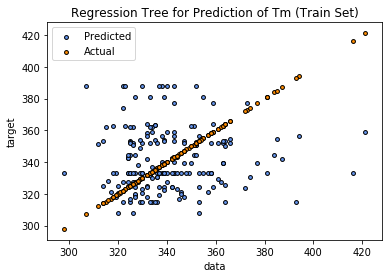

In [33]:
import random
# Plot training set results
plt.figure()
#print(df['protein'].tolist())
plt.scatter(yTrainList, y_Pred_Train, edgecolor="black",
            c="cornflowerblue", s= 15, label="Predicted")
plt.scatter(yTrainList, yTrainList, s=15, edgecolor="black",
            c="darkorange", label="Actual")

#print(XTrainFeatures)
#print(y_Pred)
plt.xlabel("data")
plt.ylabel("target")
plt.title("Regression Tree for Prediction of Tm (Train Set)")
plt.legend()
plt.show()

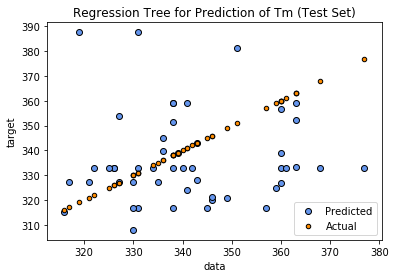

In [34]:
import random
# Plot testing set results
plt.figure()
#print(df['protein'].tolist())
plt.scatter(yTestList, y_Pred_Test, edgecolor="black",
            c="cornflowerblue", label="Predicted")
plt.scatter(yTestList, yTestList, s=20, edgecolor="black",
            c="darkorange", label="Actual")

#print(XTrainFeatures)
#print(y_Pred)
plt.xlabel("data")
plt.ylabel("target")
plt.title("Regression Tree for Prediction of Tm (Test Set)")
plt.legend()
plt.show()